## Creating Trading Signals
#### Momentum and Short Term Indicators

In [10]:
# Import libraries
import numpy as np
import pandas as pd
import yfinance as yf
import quantstats as qs
import datetime
import matplotlib.pyplot as plt
# Yahoo Finance Dataset
today = datetime.datetime.now().strftime("%Y-%m-%d")
spx = yf.download('^GSPC', start='2014-01-01', end=today)
close_prices = spx['Close']

[*********************100%***********************]  1 of 1 completed


Moving Average Indicator: We can use Python to get short and long term average prices over time (50 days and 1 year). We can then generate a buy signal when the short-term moving average crosses above the long-term moving average and a sell signal when it crosses below.

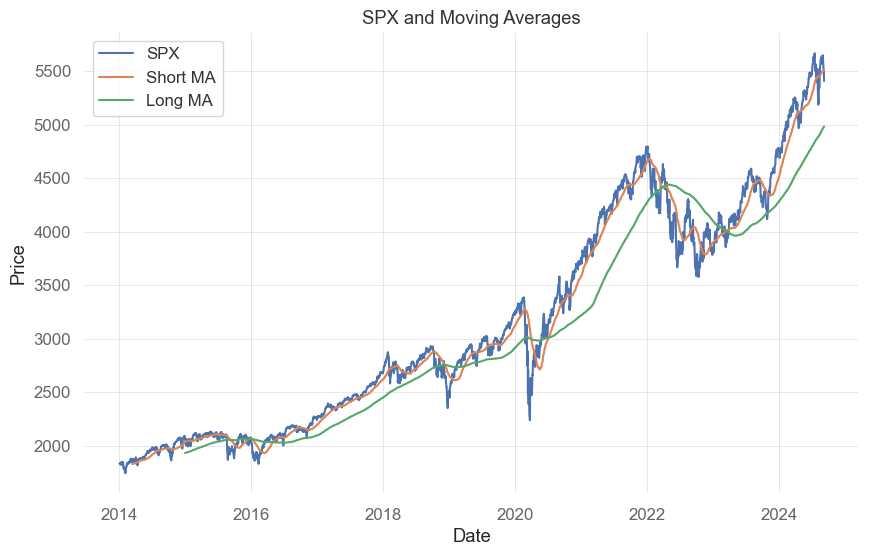

In [11]:
# Calculating Moving Averages (Indicators)
short_window = 50
long_window = 252
short_ma = close_prices.rolling(window=short_window, min_periods=short_window).mean()
long_ma = close_prices.rolling(window=long_window, min_periods=long_window).mean()
#Plotting the Moving Averages
plt.figure(figsize=(10, 6))
plt.plot(spx.index, spx['Close'], label='SPX')
plt.plot(short_ma.index, short_ma, label='Short MA')
plt.plot(long_ma.index, long_ma, label='Long MA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('SPX and Moving Averages')
plt.legend()
plt.show()

#### From Indicators to signals
Unlike indicators, which primarily describe current or past market conditions, signals provide actionable insights for future trades. Signals range from -1 to 1, representing the confidence level of a prediction. Negative values are bearish, Positive are bullish, values around 0 are neutral. The closer a signal is to the extremities (-1 or 1), the higher the confidence in the forecast. While signals guide the direction of the trade (long or short), they don't dictate the position size or the risk management strategy. The strength of the signal should be used in conjunction with other factors, such as portfolio balance, risk tolerance, and market conditions, to make informed trading decisions.

Employing the hyperbolic tangent (TanH) function is a common practice to normalize output signals to the range of [-1, 1]. This normalization helps in standardizing the prediction output, making it interpretable in the context of trading signals.

Let's begin with the simplest buy or sell signal, -1 or 1.

In [13]:
# Generating Trading Signals
signals = pd.DataFrame(index=close_prices.index)
signals['signal'] = 0.0  # Set the default to be 0
signals['short_ma'] = short_ma
signals['long_ma'] = long_ma
# When the short is above the long, buy - else go short sell.
# Note that our signal is just a simple buy or sell, -1 or 1.
signals.loc[signals['short_ma'] > signals['long_ma'], 'signal'] = 1
signals.loc[signals['short_ma'] < signals['long_ma'], 'signal'] = -1

### Computing Strategy Returns
Proper calculation of returns is essential for evaluating the performance of any trading strategy. 

Addressing Look-Ahead Bias: This occurs when a strategy uses information that would not have been available at the time of trading. To avoid this, we lag our signals by one day. This adjustment ensures that our strategy only uses information that would have been available at the market close of the previous day.

First, we compute the daily returns of the S&P 500. Next, we apply our trading signals to these returns. The signal is shifted by one day to avoid look-ahead bias.

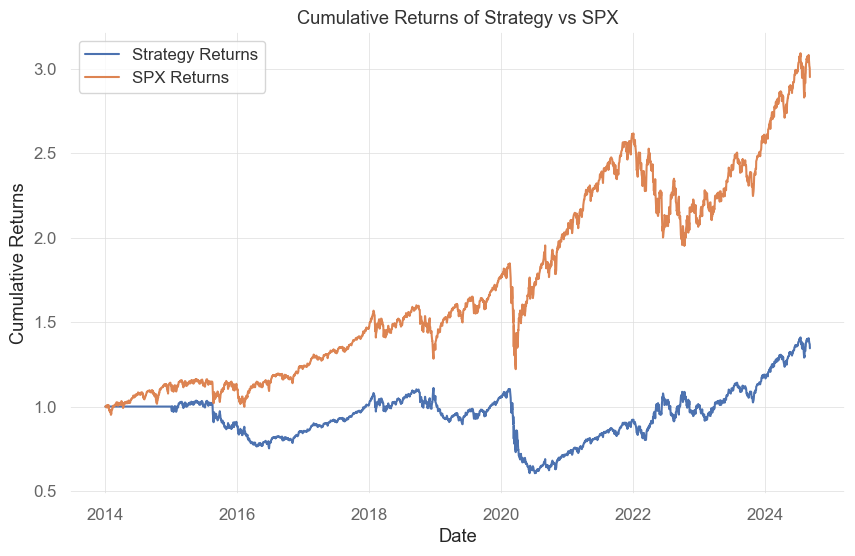

In [19]:
# Calculate daily percentage returns of SPX
spx_returns = close_prices.pct_change()
# Calculate strategy returns by multiplying SPX returns with the lagged signals
strategy_returns = spx_returns * signals['signal'].shift(1)

# Calculate the cumulative returns for both the strategy and SPX
cumulative_strategy_returns = (1 + strategy_returns).cumprod()
cumulative_spx_returns = (1 + spx_returns).cumprod()
# Plot the cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(cumulative_strategy_returns.index, cumulative_strategy_returns, label='Strategy Returns')
plt.plot(cumulative_spx_returns.index, cumulative_spx_returns, label='SPX Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns of Strategy vs SPX')
plt.legend()
plt.show()

### Position Sizing
Position sizing is a critical aspect of trading strategy that can significantly impact the risk and return profile of an investment portfolio. It involves determining the appropriate amount of capital to allocate to each investment, balancing risk and potential returns. (Kelly Criterion)

Mean-Variance Portfolio Construction: This foundational concept in modern portfolio theory helps in optimizing the allocation of weights to different assets, based on their expected returns, risks (variance), and correlations.

Meta-Labeling: An advanced technique that integrates machine learning. Meta-labeling not only decides the direction of trades (long or short) but also helps in determining the size of positions, based on the probability of a successful prediction.

For a single asset we can use volatility targeting. Volatility-targeted position sizing helps in standardizing risk across different positions, aligning each trade with the overall risk tolerance of the portfolio. This approach dynamically adjusts position sizes based on changing market volatility, contributing to more effective risk management. By clipping the maximum weight to 1, the strategy avoids the use of leverage, sticking to a more conservative investment approach.

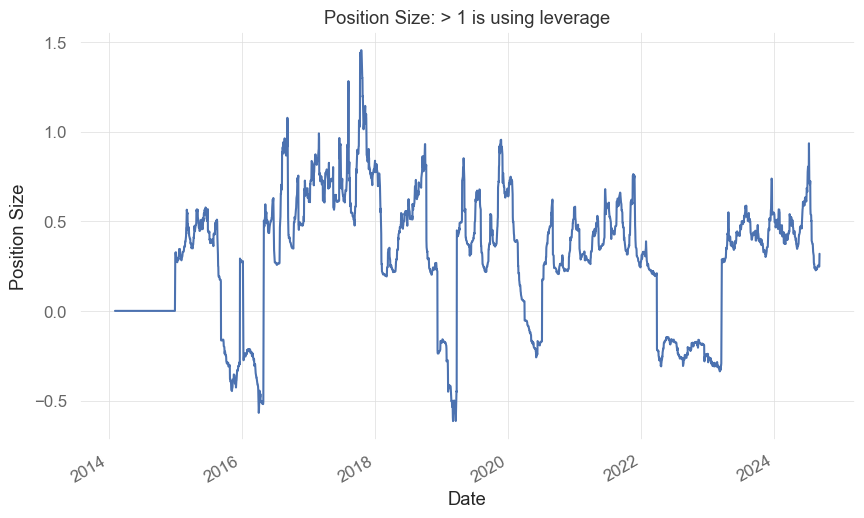

In [25]:
# Set the target volatility level
tgt_vol = 0.05
# Calculate the rolling annual standard deviation of SPX returns
# Convert to annualized standard deviation
signals['stdev'] = spx_returns.rolling(22).std() * np.sqrt(252) 
# Calculate volatility target weights
signals['vol_tgt'] = tgt_vol / signals['stdev']
# Here we use 2x leverage
signals['vol_tgt'] = signals['vol_tgt'].clip(0, 2)
# Adjust the signal by the volatility target, lagging both to avoid look-ahead bias
vol_signal = signals['signal'].shift(1) * signals['vol_tgt'].shift(1)
# Compute returns for the volatility-targeted strategy
strategy_voltgt_returns = spx_returns * vol_signal
# Plot the position sizes to see how much leverage is being used.
vol_signal.plot()
plt.title('Position Size: > 1 is using leverage')
plt.ylabel('Position Size')
plt.show()